# Imports

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from hypopt import GridSearch
from datetime import datetime
from datetime import date
import pickle
import os

In [2]:
import preprocessing

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 75

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# Preprocessing

In [4]:
training_path = '/glade/work/jdubeau/job-metrics-training.json'
data_types = {'dsnum':'object'}

df = pd.read_json(training_path, dtype = data_types)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50360 entries, 6132011 to 6785810
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   request_type     50360 non-null  object             
 1   job_start_at     50360 non-null  datetime64[ns]     
 2   job_end_at       50360 non-null  datetime64[ns]     
 3   req_mem          50360 non-null  float64            
 4   used_mem         50360 non-null  float64            
 5   dsnum            48150 non-null  object             
 6   rqst_start_at    50327 non-null  datetime64[ns, UTC]
 7   rqst_end_at      50248 non-null  datetime64[ns, UTC]
 8   dates_init       50360 non-null  bool               
 9   slat             32123 non-null  float64            
 10  nlat             32123 non-null  float64            
 11  wlon             32140 non-null  float64            
 12  elon             32140 non-null  float64            
 13  gui     

## Adding new features

Adding wall time (time from job start to job end).
This will be measured in seconds.

In [5]:
def calculate_walltime(row):
    end = row['job_end_at']
    start = row['job_start_at']
    return (end - start) / np.timedelta64(1, 's')

df['wall_time'] = df.apply(lambda row: calculate_walltime(row),
                            axis = 1)


Adding request timespan (length of time requested in the data).
This will be measured in days.

In [6]:
df['rqst_timespan'] = df.apply(lambda row:
                               (row['rqst_end_at'] - row['rqst_start_at']) / np.timedelta64(1, 'D'),
                               axis = 1)


Adding a number of features which are just the length of a list. This includes 
number of grid definitions, number of levels, number of products, and number
of stations.

In [7]:
def list_length_feature(feature, row, sep = ','):
    if row[feature] != None:
        return len(row[feature].split(sep))
    else:
        return 0

In [8]:
df['grid_def_num'] = df.apply(lambda row: list_length_feature('grid_definition', row), axis = 1)
df['level_num'] = df.apply(lambda row: list_length_feature('level', row), axis = 1)
df['product_num'] = df.apply(lambda row: list_length_feature('product', row), axis = 1)
df['station_num'] = df.apply(lambda row: list_length_feature('station', row, sep = ' '), axis = 1)

Number of parameters is similar to the four features above, but the parameters could be separated by either spaces or commas.

In [9]:
def make_params_num(row):
    if row['parameters'] != None:
        sep = ',' if ',' in row['parameters'] else ' '
        return list_length_feature('parameters', row, sep = sep)
    else:
        return 0

df['params_num'] = df.apply(lambda row: make_params_num(row), axis = 1)

We also add the rectangle area of the subset of data requested.

In [10]:
def request_area(row):
    return abs((row['nlat'] - row['slat']) * (row['elon'] - row['wlon']))

df['rqst_area_rect'] = df.apply(lambda row: request_area(row), axis = 1)

We add three columns which encode what type of request the job was.
(Purge requests can be identified from the other three columns -- 
they are neither PP, SP, nor BR.)

In [11]:
for rtype in ['PP', 'SP', 'BR']:
    df[rtype] = df.apply(lambda row: True if row['request_type'] == rtype else False, axis = 1)

Next we add a boolean column representing whether the data was converted to a different format (which is true if and only if a value for "format" was present in the rinfo string).

In [12]:
df['converted'] = df.apply(lambda row: True if row['format'] != None else False,
                           axis = 1)

Now we add boolean columns to encode the dataset: one column for each of the 
five most common datasets (so a False value in all five columsn means "other.")

In [13]:
most_common = df['dsnum'].value_counts()[:5].index.tolist()

for common_id in most_common:
    column_name = 'ds' + common_id
    df[column_name] = df.apply(lambda row: row['dsnum'] == common_id, axis = 1)


## Handling missing values

If rqst_area_rect is null, just fill it with zero (experimental)

In [14]:
df['rqst_area_rect'] = df.apply(lambda row: 
                                0 if row['rqst_area_rect'] != row['rqst_area_rect'] 
                                else row['rqst_area_rect'], 
                                axis=1)

In [15]:
other_df = preprocessing.get_df()

# Exploration / visualization

In [19]:
df.sample(5, random_state=3)

,request_type,job_start_at,job_end_at,req_mem,used_mem,dsnum,rqst_start_at,rqst_end_at,dates_init,slat,nlat,wlon,elon,gui,parameters,grid_definition,level,product,station,tindex,format,wall_time,rqst_timespan,grid_def_num,level_num,product_num,station_num,params_num,rqst_area_rect,PP,SP,BR,converted,ds084.1,ds631.1,ds083.3,ds094.0,ds083.2
6478982,PP,2021-02-05 00:09:40,2021-02-05 00:11:01,1024.0,35.679688,631.1,2000-01-01 00:00:00+00:00,2016-12-31 21:00:00+00:00,False,NaN,NaN,NaN,NaN,True,"8!ds631.1:SH2O,8!ds631.1:SMOIS,8!ds631.1:TSLB,...",None,None,None,None,5.0,None,81.0,6209.875,0,0,0,0,29,0.0,True,False,False,False,False,True,False,False,False
6603844,PP,2021-03-04 22:58:48,2021-03-04 23:01:01,1024.0,32.773438,094.0,2011-01-01 00:00:00+00:00,2021-03-04 03:00:00+00:00,False,-10.0,31.0,97.0,145.0,True,3!7-4.2-1:0.1.211,63,None,944,None,NaN,netCDF,133.0,3715.125,1,0,1,0,1,1968.0,True,False,False,True,False,False,False,True,False
6367269,PP,2021-01-08 01:11:25,2021-01-08 01:12:39,1024.0,21.824219,094.0,2011-01-01 00:00:00+00:00,2021-01-08 03:00:00+00:00,False,19.0,44.0,117.0,142.0,True,3!7-0.2-1:0.1.7,68,None,944,None,NaN,netCDF,74.0,3660.125,1,0,1,0,1,625.0,True,False,False,True,False,False,False,True,False
6485340,PP,2021-02-07 10:46:47,2021-02-07 10:47:55,1024.0,35.476562,631.1,2000-01-01 00:00:00+00:00,2016-12-31 21:00:00+00:00,False,NaN,NaN,NaN,NaN,True,"8!ds631.1:SH2O,8!ds631.1:SMOIS,8!ds631.1:TSLB,...",None,None,None,None,5.0,None,68.0,6209.875,0,0,0,0,29,0.0,True,False,False,False,False,True,False,False,False
6378861,PP,2021-01-12 21:47:32,2021-01-12 21:49:20,1024.0,29.910156,093.0,1979-01-01 00:00:00+00:00,2011-01-01 03:00:00+00:00,False,25.0,50.0,60.0,120.0,True,3!7-0.2-1:0.3.9,57,None,"119,3",None,NaN,netCDF,108.0,11688.125,1,0,2,0,1,1500.0,True,False,False,True,False,False,False,False,False


In [18]:
other_df.sample(5, random_state=3)

,request_type,job_start_at,job_end_at,req_mem,used_mem,dsnum,rqst_start_at,rqst_end_at,dates_init,slat,nlat,wlon,elon,gui,parameters,grid_definition,level,product,station,tindex,format,wall_time,rqst_timespan,grid_def_num,level_num,product_num,station_num,params_num,rqst_area_rect,PP,SP,BR,converted,ds084.1,ds631.1,ds083.3,ds094.0,ds083.2
6478982,PP,2021-02-05 00:09:40,2021-02-05 00:11:01,1024.0,35.679688,631.1,2000-01-01 00:00:00+00:00,2016-12-31 21:00:00+00:00,False,NaN,NaN,NaN,NaN,True,"8!ds631.1:SH2O,8!ds631.1:SMOIS,8!ds631.1:TSLB,...",None,None,None,None,5.0,None,81.0,6209.875,0,0,0,0,29,0.0,True,False,False,False,False,True,False,False,False
6603844,PP,2021-03-04 22:58:48,2021-03-04 23:01:01,1024.0,32.773438,094.0,2011-01-01 00:00:00+00:00,2021-03-04 03:00:00+00:00,False,-10.0,31.0,97.0,145.0,True,3!7-4.2-1:0.1.211,63,None,944,None,NaN,netCDF,133.0,3715.125,1,0,1,0,1,1968.0,True,False,False,True,False,False,False,True,False
6367269,PP,2021-01-08 01:11:25,2021-01-08 01:12:39,1024.0,21.824219,094.0,2011-01-01 00:00:00+00:00,2021-01-08 03:00:00+00:00,False,19.0,44.0,117.0,142.0,True,3!7-0.2-1:0.1.7,68,None,944,None,NaN,netCDF,74.0,3660.125,1,0,1,0,1,625.0,True,False,False,True,False,False,False,True,False
6485340,PP,2021-02-07 10:46:47,2021-02-07 10:47:55,1024.0,35.476562,631.1,2000-01-01 00:00:00+00:00,2016-12-31 21:00:00+00:00,False,NaN,NaN,NaN,NaN,True,"8!ds631.1:SH2O,8!ds631.1:SMOIS,8!ds631.1:TSLB,...",None,None,None,None,5.0,None,68.0,6209.875,0,0,0,0,29,0.0,True,False,False,False,False,True,False,False,False
6378861,PP,2021-01-12 21:47:32,2021-01-12 21:49:20,1024.0,29.910156,093.0,1979-01-01 00:00:00+00:00,2011-01-01 03:00:00+00:00,False,25.0,50.0,60.0,120.0,True,3!7-0.2-1:0.3.9,57,None,"119,3",None,NaN,netCDF,108.0,11688.125,1,0,2,0,1,1500.0,True,False,False,True,False,False,False,False,False


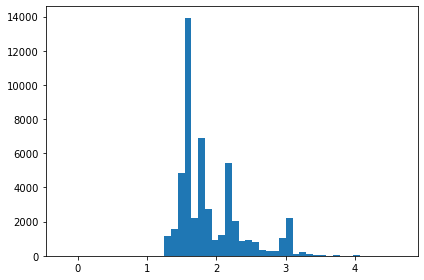

In [15]:
plt.hist(np.log10(df['used_mem']), bins=50)
plt.show()

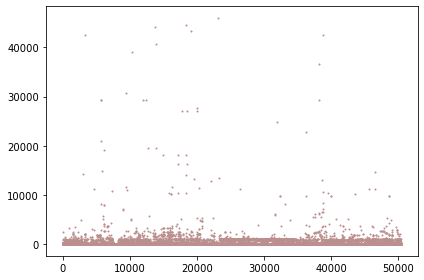

In [16]:
plt.scatter(range(df.shape[0]), df['used_mem'], s=1, color='rosybrown')
plt.xlabel('')
plt.show()

In [17]:
df[df.used_mem > 2000].shape[0]

303

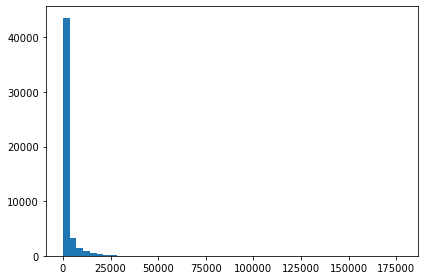

In [18]:
plt.hist(df['wall_time'], bins=50)
plt.show()

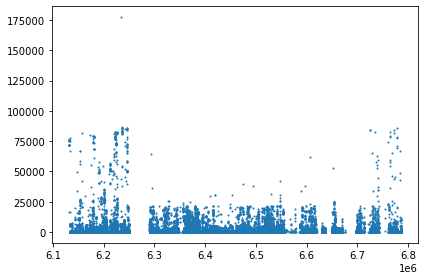

In [19]:
plt.scatter(df.index, df['wall_time'], s=1)
plt.show()

In [20]:
df[df.wall_time > 25000].shape[0]

388

# Wall time model

## Feature selection

In [ ]:
time_df = df[df.rqst_timespan.notnull() & df.rqst_area_rect.notnull()]
time_X_features = ['PP', 'SP', 'BR', 'rqst_timespan', 'rqst_area_rect', 'converted',
              'params_num', 'grid_def_num', 'level_num',
              'ds084.1', 'ds631.1', 'ds083.3', 'ds094.0', 'ds083.2']
time_y_features = ['wall_time']

time_X = time_df[time_X_features]
time_y = time_df[time_y_features]

## Train/validation/test split

In [ ]:
time_train_amt = 0.5
time_val_amt = 0.25
time_test_amt = 0.25

In [ ]:
time_X_train, time_X_target, time_y_train, time_y_target = \
                train_test_split(time_X, time_y, 
                test_size=1-time_train_amt, 
                random_state = 3)
time_X_val, time_X_test, time_y_val, time_y_test = \
                train_test_split(time_X_target, time_y_target,
                                 test_size = time_test_amt/time_train_amt,
                                 random_state = 3)


In [ ]:
time_y_train = np.ravel(time_y_train)
time_y_val = np.ravel(time_y_val)
time_y_test = np.ravel(time_y_test)

## Scaling

In [ ]:
time_scaler = StandardScaler()
time_scaler.fit(time_X_train)

time_X_train_norm = time_scaler.transform(time_X_train)
time_X_val_norm = time_scaler.transform(time_X_val)
time_X_test_norm = time_scaler.transform(time_X_test)

## Trees, Forest, Gradient Boosts

### Tree

In [ ]:
time_tree_param_grid = {'random_state':[3], 'max_depth':range(2,15)}
time_tree_gs = GridSearch(model=DecisionTreeRegressor(), 
                          param_grid=time_tree_param_grid,
                          parallelize=False)
time_tree_gs.fit(time_X_train_norm, time_y_train, time_X_val_norm, time_y_val)

In [ ]:
time_tree_gs.best_params

In [ ]:
time_tree = DecisionTreeRegressor(**time_tree_gs.best_params)
#time_tree_params = {'max_depth': 14, 'random_state': 3}
time_tree = DecisionTreeRegressor(**time_tree_params)
time_tree.fit(time_X_train_norm, time_y_train)

### Forest

In [ ]:
time_forest_param_grid = {'random_state':[3], 'max_depth':range(2,15),
                     'n_estimators':[100,200,300,500]}
time_forest_gs = GridSearch(model=RandomForestRegressor(), 
                            param_grid=time_forest_param_grid,
                            parallelize=False)
time_forest_gs.fit(time_X_train_norm, time_y_train, time_X_val_norm, time_y_val)

In [ ]:
time_forest_gs.best_params

In [ ]:
time_forest = RandomForestRegressor(**time_forest_gs.best_params)
time_forest_params = {'max_depth': 14, 'n_estimators': 500, 'random_state': 3}
#time_forest = RandomForestRegressor(**time_forest_params)
time_forest.fit(time_X_train_norm, time_y_train)

### Gradient boosted trees

In [ ]:
time_gboost_param_grid = {'random_state':[3], 
                          'max_depth':range(2,15),
                          'n_estimators':[100,200,300,500]}
time_gboost_gs = GridSearch(model=GradientBoostingRegressor(),
                            param_grid=time_gboost_param_grid,
                            parallelize=False)
time_gboost_gs.fit(time_X_train_norm, time_y_train, time_X_val_norm, time_y_val)

In [ ]:
time_gboost_gs.best_params

In [ ]:
time_gboost = GradientBoostingRegressor(**time_gboost_gs.best_params)
time_gboost_params = {'max_depth': 9, 'n_estimators': 200, 'random_state': 3}
#time_gboost = GradientBoostingRegressor(**time_gboost_params)
time_gboost.fit(time_X_train_norm, time_y_train)

## Linear regressors

### Basic linear regression

In [ ]:
linear = LinearRegression().fit(time_X_train_norm, time_y_train)

In [ ]:
linear.coef_

### Ridge regression

In [ ]:
ridge10 = Ridge(alpha=10).fit(time_X_train_norm, time_y_train)
ridge1 = Ridge(alpha=1).fit(time_X_train_norm, time_y_train)
ridge01 = Ridge(alpha=0.1).fit(time_X_train_norm, time_y_train)

In [ ]:
ridge10.coef_

### Lasso regression

In [ ]:
lasso = Lasso(alpha=0.01, max_iter=100000).fit(time_X_train_norm, time_y_train)

In [ ]:
lasso.coef_

# Used memory model

In [ ]:
mem_df = df[df.rqst_timespan.notnull() & df.rqst_area_rect.notnull()]
mem_X_features = ['PP', 'SP', 'BR', 'rqst_timespan', 'rqst_area_rect', 'converted',
              'params_num', 'grid_def_num', 'level_num',
              'ds084.1', 'ds631.1', 'ds083.3', 'ds094.0', 'ds083.2']
mem_y_features = ['used_mem']

mem_X = mem_df[mem_X_features]
mem_y = mem_df[mem_y_features]

## Train/validation/test split

In [ ]:
mem_train_amt = 0.5
mem_val_amt = 0.25
mem_test_amt = 0.25

In [ ]:
mem_X_train, mem_X_target, mem_y_train, mem_y_target = \
                        train_test_split(mem_X, mem_y, 
                                         test_size=1-mem_train_amt, 
                                         random_state = 3)
mem_X_val, mem_X_test, mem_y_val, mem_y_test = \
                        train_test_split(mem_X_target, mem_y_target,
                                         test_size = mem_test_amt/mem_train_amt,
                                         random_state = 3)


In [ ]:
mem_y_train = np.ravel(mem_y_train)
mem_y_val = np.ravel(mem_y_val)
mem_y_test = np.ravel(mem_y_test)

## Scaling

In [ ]:
mem_scaler = StandardScaler()
mem_scaler.fit(mem_X_train)

mem_X_train_norm = mem_scaler.transform(mem_X_train)
mem_X_val_norm = mem_scaler.transform(mem_X_val)
mem_X_test_norm = mem_scaler.transform(mem_X_test)

## Trees, Forest, Gradient Boosts

### Tree

In [ ]:
mem_tree_param_grid = {'random_state':[3], 'max_depth':range(2,15)}
mem_tree_gs = GridSearch(model=DecisionTreeRegressor(), 
                         param_grid=mem_tree_param_grid,
                         parallelize=False)
mem_tree_gs.fit(mem_X_train_norm, mem_y_train, mem_X_val_norm, mem_y_val)


In [ ]:
mem_tree_gs.best_params

In [ ]:
mem_tree_params = {'max_depth': 11, 'random_state': 3}
mem_tree = DecisionTreeRegressor(**mem_tree_gs.best_params)
#mem_tree = DecisionTreeRegressor(**mem_tree_params)
mem_tree.fit(mem_X_train_norm, mem_y_train)

### Forest

In [ ]:
mem_forest_param_grid = {'random_state':[3], 'max_depth':range(2,15),
                     'n_estimators':[100,200,300,500]}
mem_forest_gs = GridSearch(model=RandomForestRegressor(), 
                           param_grid=mem_forest_param_grid,
                           parallelize=False)
mem_forest_gs.fit(mem_X_train_norm, mem_y_train, mem_X_val_norm, mem_y_val)

In [ ]:
mem_forest_gs.best_params

In [ ]:
mem_forest = RandomForestRegressor(**mem_forest_gs.best_params)
mem_forest_params = {'max_depth': 13, 'n_estimators': 100, 'random_state': 3}
#mem_forest = RandomForestRegressor(**mem_forest_params)
mem_forest.fit(mem_X_train_norm, mem_y_train)

### Gradient boosted trees

In [ ]:
mem_gboost_param_grid = {'random_state':[3], 
                          'max_depth':range(2,15),
                          'n_estimators':[100,200,300,500]}
mem_gboost_gs = GridSearch(model=GradientBoostingRegressor(),
                            param_grid=mem_gboost_param_grid,
                            parallelize=False)
mem_gboost_gs.fit(mem_X_train_norm, mem_y_train, mem_X_val_norm, mem_y_val)

In [ ]:
mem_gboost_gs.best_params

# Classification problem

## Memory categories

In [15]:
mem_bin_cutoffs = [50, 100, 200, 500, 1000, 2000, 10000, 20000, 50000, 100000]

bin_sizes = [df[df.used_mem < mem_bin_cutoffs[0]].shape[0]]
for i in range(1, len(mem_bin_cutoffs)):
    current_bin_size = df[(df.used_mem >= mem_bin_cutoffs[i-1])
                        & (df.used_mem < mem_bin_cutoffs[i])].shape[0]
    bin_sizes.append(current_bin_size)


In [16]:
def print_mem_categories():
    print(f"0: < {mem_bin_cutoffs[0]}MB ({bin_sizes[0]} entries)")
    for i in range(1, len(mem_bin_cutoffs)):
        print(f"{i}: >= {mem_bin_cutoffs[i-1]}MB"
              + f" and < {mem_bin_cutoffs[i]}MB"
              + f" ({bin_sizes[i]} entries)")

In [17]:
print_mem_categories()

0: < 50MB (22965 entries)
1: >= 50MB and < 100MB (11126 entries)
2: >= 100MB and < 200MB (8623 entries)
3: >= 200MB and < 500MB (3169 entries)
4: >= 500MB and < 1000MB (1639 entries)
5: >= 1000MB and < 2000MB (2535 entries)
6: >= 2000MB and < 10000MB (248 entries)
7: >= 10000MB and < 20000MB (33 entries)
8: >= 20000MB and < 50000MB (22 entries)
9: >= 50000MB and < 100000MB (0 entries)


In [18]:
def mem_category(row):
    mem = row['used_mem']
    if mem < mem_bin_cutoffs[0]:
        return 0
    for i in range(1, len(mem_bin_cutoffs)):
        if mem >= mem_bin_cutoffs[i-1] and mem < mem_bin_cutoffs[i]:
            return i
    return None

In [19]:
df['mem_category'] = df.apply(lambda row: mem_category(row), axis=1)

## Feature selection

In [20]:
class_df = df[df.rqst_timespan.notnull() & df.rqst_area_rect.notnull()]
class_X_features = ['PP', 'SP', 'BR', 'rqst_timespan', 'rqst_area_rect', 'converted',
              'params_num', 'grid_def_num', 'level_num',
              'ds084.1', 'ds631.1', 'ds083.3', 'ds094.0', 'ds083.2']
class_y_features = ['req_mem', 'used_mem', 'mem_category']

class_X = class_df[class_X_features]
class_y = class_df[class_y_features]

## Train/validation/test split

In [21]:
class_train_amt = 0.5
class_val_amt = 0.25
class_test_amt = 0.25

In [22]:
class_X_train, class_X_target, class_y_train_full, class_y_target_full = \
                train_test_split(class_X, class_y, 
                test_size=1-class_train_amt, 
                random_state = 3)
class_X_val, class_X_test, class_y_val_full, class_y_test_full = \
                train_test_split(class_X_target, class_y_target_full,
                                 test_size = class_test_amt/class_train_amt,
                                 random_state = 3)

In [23]:
print(class_y_train_full[:5])

         req_mem    used_mem  mem_category
6220696   1024.0   61.992188             1
6332429   4096.0  160.144531             2
6410021   2048.0   66.574219             1
6197047  20480.0  490.234375             3
6222743  20480.0   36.976562             0


In [24]:
class_y_train = np.ravel(class_y_train_full['mem_category'])
class_y_val = np.ravel(class_y_val_full['mem_category'])
class_y_test = np.ravel(class_y_test_full['mem_category'])

In [25]:
print(class_y_train[:5])

[1 2 1 3 0]


## Scaling

In [26]:
class_scaler = StandardScaler()
class_scaler.fit(class_X_train)

class_X_train_norm = class_scaler.transform(class_X_train)
class_X_val_norm = class_scaler.transform(class_X_val)
class_X_test_norm = class_scaler.transform(class_X_test)

## Trees, Forest, Gradient Boosts

### Tree

In [38]:
class_tree_param_grid = {'random_state':[3], 'max_depth':range(2,20), 'class_weight':['balanced']}
class_tree_gs = GridSearch(model=DecisionTreeClassifier(), 
                          param_grid=class_tree_param_grid,
                          parallelize=False)
class_tree_gs.fit(class_X_train_norm, class_y_train, class_X_val_norm, class_y_val)

DecisionTreeClassifier(class_weight='balanced', max_depth=19, random_state=3)

In [39]:
class_tree_gs.best_params

{'class_weight': 'balanced', 'max_depth': 19, 'random_state': 3}

In [40]:
class_tree = class_tree_gs.best_estimator_

### Forest

In [42]:
class_forest_param_grid = {'random_state':[3], 'max_depth':range(2,15),
                     'n_estimators':[100,200,300,500], 'class_weight':['balanced']}
class_forest_gs = GridSearch(model=RandomForestClassifier(), 
                            param_grid=class_forest_param_grid,
                            parallelize=False)
class_forest_gs.fit(class_X_train_norm, class_y_train, class_X_val_norm, class_y_val)

RandomForestClassifier(class_weight='balanced', max_depth=14, n_estimators=500,
                       random_state=3)

In [43]:
class_forest_gs.best_params

{'class_weight': 'balanced',
 'max_depth': 14,
 'n_estimators': 300,
 'random_state': 3}

In [27]:
#class_forest = class_forest_gs.best_estimator_
class_forest = RandomForestClassifier(class_weight='balanced',
                                      max_depth=14,
                                      n_estimators=300,
                                      random_state=3)
class_forest.fit(class_X_train_norm, class_y_train)

RandomForestClassifier(class_weight='balanced', max_depth=14, n_estimators=300,
                       random_state=3)

### Gradient boosted trees

In [ ]:
class_gboost_param_grid = {'random_state':[3], 'max_depth':range(2,15),
                     'n_estimators':[100,200,300,500]}
class_gboost_gs = GridSearch(model=GradientBoostingClassifier(), 
                            param_grid=class_gboost_param_grid,
                            parallelize=False)
class_gboost_gs.fit(class_X_train_norm, class_y_train, class_X_val_norm, class_y_val)

In [ ]:
class_gboost_gs.best_params

In [ ]:
class_gboost = class_gboost_gs.best_estimator_

In [44]:
class_gboost = GradientBoostingClassifier(random_state=3, max_depth=14, n_estimators=150)
class_gboost.fit(class_X_train_norm, class_y_train)

GradientBoostingClassifier(max_depth=14, n_estimators=150, random_state=3)

## Linear regressors

In [29]:
logist = LogisticRegression(max_iter=1000, class_weight='balanced')
logist.fit(class_X_train_norm, class_y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

# Model evaluation

In [28]:
def score_model(target, model):
    if target == 'time':
        train_score = round(model.score(time_X_train_norm, time_y_train), 4)
        val_score = round(model.score(time_X_val_norm, time_y_val), 4)
    elif target == 'mem':
        train_score = round(model.score(mem_X_train_norm, mem_y_train), 4)
        val_score = round(model.score(mem_X_val_norm, mem_y_val), 4)
    elif target == 'class':
        train_score = round(model.score(class_X_train_norm, class_y_train), 4)
        val_score = round(model.score(class_X_val_norm, class_y_val), 4)
    print(f"Training score: {train_score}")
    print(f"Validation score: {val_score}")

In [29]:
def print_feature_importances(target, model):
    if target == 'time':
        X_features = time_X_features
    elif target == 'mem':
        X_features = mem_X_features
    elif target == 'class':
        X_features = class_X_features
        
    name_val_pairs = list(zip(X_features, 
                              [round(100*val,3) 
                               for val in model.feature_importances_]
                              ))
    
    print('\n'.join([str(item) for item in name_val_pairs]))

In [30]:
def plot_performance(target, model, scale='linear', goal_line=True):
    ax = plt.gca()
    
    if target == 'time':
        pred = model.predict(time_X_val_norm)
        val = time_y_val
        
    else:
        pred = model.predict(mem_X_val_norm)
        val = mem_y_val
        
    ax.scatter(pred, val, color='blueviolet', s=1.2)
        
    if goal_line:
        max_value = int(max(np.amax(pred), np.amax(val)))
        x = np.array(range(0,max_value))
        plt.plot(x, x, color='blue')
        
    plt.xscale(scale)
    plt.yscale(scale)
    plt.xlabel("Predicted value")
    plt.ylabel("Actual value")

In [31]:
def plot_cm(model):
    plot_confusion_matrix(model, class_X_val_norm, 
                          class_y_val, normalize='true', 
                          values_format='.2f')

In [32]:
def print_cr(model):
    print(classification_report(class_y_val, model.predict(class_X_val_norm)))

In [33]:
def auc(model):
    print(roc_auc_score(class_y_val, 
                        model.predict_proba(class_X_val_norm),
                        average='weighted',
                        multi_class='ovr'))

In [34]:
auc(class_forest)

0.9718435717819608


In [35]:
score_model('class', class_forest)

Training score: 0.8894
Validation score: 0.8451


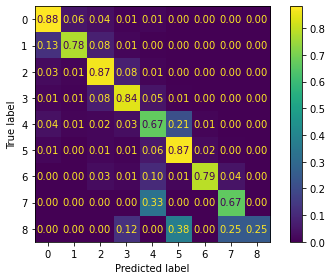

In [36]:
plot_cm(class_forest)

In [37]:
print_feature_importances('class', class_forest)

('PP', 5.428)
('SP', 7.407)
('BR', 3.271)
('rqst_timespan', 27.742)
('rqst_area_rect', 14.062)
('converted', 6.821)
('params_num', 15.014)
('grid_def_num', 3.055)
('level_num', 7.526)
('ds084.1', 4.638)
('ds631.1', 1.42)
('ds083.3', 1.387)
('ds094.0', 0.918)
('ds083.2', 1.311)


# Model persistence

In [38]:
save_path = '/glade/work/jdubeau/model-saves/'

def save_trained_model(name, date=True
                       model, model_df, 
                       X_train, y_train_full, 
                       X_val, y_val_full, 
                       X_test, y_test_full):
    
    folder_path = save_path + name
    if date:
        day = date.today()
        time = datetime.now().strftime("%H:%M")
        folder_path = folder_path + str(day)+ '-' +str(time) + '/'

    os.makedirs(os.path.dirname(folder_path), exist_ok=True)
    
    pickle.dump(model, open(folder_path+'model.pkl', 'wb'))
    pickle.dump(model_df, open(folder_path+'model_df.pkl', 'wb'))
    pickle.dump(X_train, open(folder_path+'X_train.pkl', 'wb'))
    pickle.dump(y_train_full, open(folder_path+'y_train_full.pkl', 'wb'))
    pickle.dump(X_val, open(folder_path+'X_val.pkl', 'wb'))
    pickle.dump(y_val_full, open(folder_path+'y_val_full.pkl', 'wb'))
    pickle.dump(X_test, open(folder_path+'X_test.pkl', 'wb'))
    pickle.dump(y_test_full, open(folder_path+'y_test_full.pkl', 'wb'))

In [39]:
save_trained_model('class_forest',
                   class_forest, class_df,
                   class_X_train_norm, class_y_train_full,
                   class_X_val_norm, class_y_val_full,
                   class_X_test_norm, class_y_test_full)